Cuda is  True
Cuda num is  0


C:\Users\jamily\AppData\Roaming\Python\Python39\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


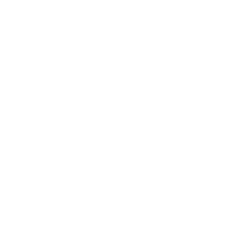

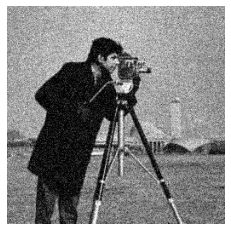

C:\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


MultiscaleBACON(
  (linear): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (output_linear): ModuleList(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Linear(in_features=256, out_features=1, bias=True)
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (filters): ModuleList(
    (0): FourierLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): FourierLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (2): FourierLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (3): FourierLayer(
      (linear): Linear(in_features=2

KeyboardInterrupt: 

In [1]:
from MinPy import task
import torch as t
from MinPy.toolbox.plot import plot_tra
import matplotlib.pyplot as plt
t.autograd.set_detect_anomaly(True)

# m,n分别定义读取的图片的长宽，不用管原始是多少，这里会rescale到相应的大小
m,n = 256,256
# 第一类神经网络，神经网络输出本身就是矩阵：
# 1. dmf:深度矩阵分解模型
# 2. dip:Deep Image Prior
# 3. fc: 全连接神经网络组成的AutoEncoderDecoder
# model_name = 'dip' #'dip','fc'
# para = [m,m,n,n]

# 第二类神经网络，从坐标映射到矩阵值：
# 1. fp: F-Principle, ReLU激活的全连接神经网络， R^2 -> R^1
# 2. fourier: multiply filter network ，当filter为傅里叶基的情况
# 3. garbor: multiply filter network ，当filter为Garbor基的情况
model_name = 'fourier'#'fourier'#'garbor'
para = [2,256,1]

# model_name = 'mulbacon'
# para = [256,128,4]

# model_name = 'msn'
# para = [m,n]

# 第三类神经网络，混合
# model_name = 'multi_net'
# para = [m,m,n,n]

# 读取图片的路径设置，可自行替换
data_path='./train_pics/Cameraman.jpg'
# 设置mask的模式，
# 为random时为随机丢失，和之后的random_rate相配合。
# 为patch时，为丢失固定位置的像素，无需额外设置。
# 为fixed时需要设置mask_path确定掩码图像
mask_mode='random'#'patch_num' # 'patch','fixed'
# 当mask_mode为fixed时启用，读取掩码矩阵
mask_path='./masks/mask.png'
# 当mask_mode为random时启用，为丢失像素值的比例 [0,1]
random_rate=0
# 正则项的添加，包含四种正则项
# 使用 None 代表无需正则
# 使用 'TV' 代表使用默认参数的TV正则
# 使用 'AIR' 代表使用默认参数的AIR自适应正则
# 使用 'NN' 代表使用一个卷积神经网络正则
# 使用 'eta' 代表自定义混合正则，由四项系数控制，分别控制['TV','row of AIR','col of AIR','NN']正则的系数，当填None时代表不使用该正则
reg_mode = None # 'TV',''AIR','NN',None,'eta':custom
# 使用 'eta' 时启用
eta = [1e2,None,None,None]

# 训练批次
epoch=1001

# 定义训练任务，在task.py中定义，对于去噪或是其他逆问题只需要修改这个函数即可
task_dmf = task.shuffle_task(m=m,n=n,data_path=data_path,mask_mode=mask_mode,random_rate=random_rate,
                     mask_path=mask_path,given_mask=None,para=para,input_mode='masked',
                    std_b=1e-3,reg_mode=reg_mode,model_name=model_name,pro_mode='mask',
                                 opt_type='Adam',shuffle_mode='I',verbose=True,std_w=1e-3,act='tanh',
                             patch_num=10,net_list=['fp','garbor'],n_layers=8,scale_factor=2,model_load_path=None,
                             task_type='denoising',noise_dict={'type':'gaussian','sigma':0.1,'SNR':0.1,'lam':0.1},sample_mode='random')
# 对定义的训练任务进行训练
# 通过print_epoch,imshow_epoch参数调节每隔多少次输出一次
# 通过imshow 调节是否输出图像
task_dmf.train(epoch=epoch,print_epoch=100,imshow_epoch=100,plot_mode='gray',
                   verbose=True,imshow=True,stop_err=None,eta=eta,
                   model_save_path='./save_models/test.pth',model_save=False,
                   fid_name=None)
# TODO 5. 计算并传入input_x,input_y
# 绘制出收敛过程训练误差(Obs_MSE)和测试误差(Unk_MSE)的变化情况
plot_tra(pro_list=task_dmf.pro_list,color='r',label='MSE',pointsize=50)
plt.xlabel('Obs_MSE')
plt.ylabel('Unk_MSE')
plt.show()